In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# filter warnings
warnings.filterwarnings('ignore')

## EDA

In [ ]:
# Завантажимо набір даних і попередньо переглянемо:
data_path = 'https://raw.githubusercontent.com/alexvekh/DL-course/main/data/ConcreteStrengthData.csv'
df = pd.read_csv(data_path)
df.sample(5, random_state=42)

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
31,266.0,114.0,0.0,228.0,0.0,932.0,670.0,365,52.91
109,362.6,189.0,0.0,164.9,11.6,944.7,755.8,7,55.90
136,389.9,189.0,0.0,145.9,22.0,944.7,755.8,28,74.50
88,362.6,189.0,0.0,164.9,11.6,944.7,755.8,3,35.30
918,145.0,0.0,179.0,202.0,8.0,824.0,869.0,28,10.54


In [ ]:
df.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [ ]:
# Виведемо базову інформацію про набір даних.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CementComponent            1030 non-null   float64
 1   BlastFurnaceSlag           1030 non-null   float64
 2   FlyAshComponent            1030 non-null   float64
 3   WaterComponent             1030 non-null   float64
 4   SuperplasticizerComponent  1030 non-null   float64
 5   CoarseAggregateComponent   1030 non-null   float64
 6   FineAggregateComponent     1030 non-null   float64
 7   AgeInDays                  1030 non-null   int64  
 8   Strength                   1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


In [ ]:
df.corr().style.background_gradient()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
CementComponent,1.000000,-0.275216,-0.397467,-0.081587,0.092386,-0.109349,-0.222718,0.081946,0.497832
BlastFurnaceSlag,-0.275216,1.000000,-0.323580,0.107252,0.043270,-0.283999,-0.281603,-0.044246,0.134829
FlyAshComponent,-0.397467,-0.323580,1.000000,-0.256984,0.377503,-0.009961,0.079108,-0.154371,-0.105755
WaterComponent,-0.081587,0.107252,-0.256984,1.000000,-0.657533,-0.182294,-0.450661,0.277618,-0.289633
SuperplasticizerComponent,0.092386,0.043270,0.377503,-0.657533,1.000000,-0.265999,0.222691,-0.192700,0.366079
CoarseAggregateComponent,-0.109349,-0.283999,-0.009961,-0.182294,-0.265999,1.000000,-0.178481,-0.003016,-0.164935
FineAggregateComponent,-0.222718,-0.281603,0.079108,-0.450661,0.222691,-0.178481,1.000000,-0.156095,-0.167241
AgeInDays,0.081946,-0.044246,-0.154371,0.277618,-0.192700,-0.003016,-0.156095,1.000000,0.328873
Strength,0.497832,0.134829,-0.105755,-0.289633,0.366079,-0.164935,-0.167241,0.328873,1.000000


### Аналіз датасету:
- Спостерігаємо 9 ознак в дадтасеті.
- Пропусків нема, тому відновлення значень або видалення об'єктів з пропусками не требується.
- Всі ознаки числові, тому не треба поділу на числові та категоріальні, а на всв ознаки порахуємо *кореляцію*
- Цільова ознака "Strength" - непереревне число,- то ж для її прошнозу застосовуємо регресію.
- Жодної високої кореляції між ознаками не виявлена, тому всі ознаки залишаються для навчання.




## Feature preprocessing

In [ ]:
# Train/test split
# Представимо матрицю ознак X та вектор таргетової змінної y як numpy-масив.
X = df.drop('Strength', axis =1)#.values
y = df['Strength']#.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
class BigmartDataset(Dataset):
    def __init__(self, X, y, scale=True):
        self.X = X.values # from Pandas DataFrame to NumPy array
        self.y = y.values

        if scale:
            sc = StandardScaler()
            self.X = sc.fit_transform(self.X)

    def __len__(self):
        #return size of a dataset
        return len(self.y)

    def __getitem__(self, idx):
        #supports indexing using dataset[i] to get the i-th row in a dataset

        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)

        return X, y

# Створимо об’єкти навчального та тестового Dataset
train_dataset = BigmartDataset(X_train, y_train)
test_dataset = BigmartDataset(X_test, y_test)

In [ ]:
# Створимо об’єкти DataLoader для наших Dataset-ів, щоб ділити на батчі
train_dataloader = DataLoader(train_dataset,
                              batch_size=200,
                              num_workers=4
                             )

test_dataloader = DataLoader(test_dataset,
                              batch_size=200,
                              num_workers=4
                             )

In [ ]:
# Важливо переконатись, що DataLoader коректно генерує батчі (повертає дані частинами) перед тим, як ми почнемо процес навчання моделі.
next(iter(train_dataloader))

[tensor([[-1.2470,  1.8272, -0.8006,  ...,  1.2080, -1.1914, -0.2958],
         [-0.6137, -0.8646,  1.1712,  ...,  1.3314,  0.3049, -0.5233],
         [ 0.4901, -0.8646, -0.8006,  ..., -0.0767,  0.1314,  5.1800],
         ...,
         [-0.3067, -0.8646,  0.7692,  ...,  0.1751,  1.4791, -0.7020],
         [ 0.5820, -0.8646, -0.8006,  ...,  0.9282,  0.4434, -0.2958],
         [-1.0990, -0.8646,  1.7941,  ...,  1.0757,  0.1202,  0.1592]]),
 tensor([37.4300, 26.0500, 38.8900, 26.1500, 11.4800, 33.0600, 15.6900, 67.3100,
         28.6300, 32.0700, 39.4500, 39.2300, 39.3800, 27.3400, 31.5400, 41.3000,
         58.8000, 45.0800, 51.7200, 55.5100, 23.8500, 68.7500, 53.1000, 15.0300,
         67.7000, 17.5800, 39.9400, 24.5000, 11.9600, 67.1100, 79.9900, 23.3500,
         33.9400, 17.5400, 13.0900, 57.2300, 19.9900, 23.7400, 44.8700, 65.2000,
         56.4000, 12.7900, 23.7000, 33.6900, 32.7200, 40.6000, 28.9900, 82.6000,
         63.5300, 17.2200, 29.8700, 71.9900, 31.2700, 52.2000, 34.6700, 

In [ ]:
# Створимо клас, який буде описувати нашу нейронну мережу.
class LinearModel(torch.nn.Module):
    def __init__(self, in_dim, out_dim=1):
        super().__init__()

        self.features = torch.nn.Sequential(
            nn.Linear(in_dim, 256),
            torch.nn.ReLU(),

            nn.Linear(256, 128),
            torch.nn.ReLU(),

            nn.Linear(128, 64),
            torch.nn.ReLU(),

            nn.Linear(64, out_dim),
        )

    def forward(self, x):
        output = self.features(x)
        return output

In [ ]:
# Initialize the model
model = LinearModel(in_dim=X_train.shape[1], out_dim=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
# momentum=0.9 — додатковий параметр, який допомагає покращити сходження, особливо в задачах з великими змінами градієнтів.


train_losses = []
train_rmses = []
train_mses = []
train_maes = []
train_r2 = []
test_losses = []
test_rmses = []
test_mses = []
test_maes = []
test_r2 = []


# Train the model

num_epochs = 200

for epoch in range(num_epochs):

    # Train step

    model.train()

    y_pred_train = []

    for data in train_dataloader:
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        targets = targets.reshape((targets.shape[0], 1))
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_train.extend(outputs.cpu().detach().numpy())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE: {RMSE(y_train, y_pred_train):.4f},  MSE: {mean_squared_error(y_train, y_pred_train):.4f},  MAE: {mean_absolute_error(y_train, y_pred_train):.4f},  r2: {r2_score(y_train, y_pred_train):.4f}')

    train_rmses.append(RMSE(y_train, y_pred_train))
    train_losses.append(loss.cpu().detach().numpy())
    train_mses.append(mean_squared_error(y_train, y_pred_train))
    train_maes.append(mean_absolute_error(y_train, y_pred_train))
    train_r2.append(r2_score(y_train, y_pred_train))

    # Eval step

    model.eval()

    y_pred_test = []

    with torch.no_grad():

        for data in test_dataloader:
            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()
            targets = targets.reshape((targets.shape[0], 1))
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # No backward pass

            y_pred_test.extend(outputs.cpu().detach().numpy())

        test_rmses.append(RMSE(y_test, y_pred_test))
        test_losses.append(loss.cpu().detach().numpy())
        test_mses.append(mean_squared_error(y_test, y_pred_test))
        test_maes.append(mean_absolute_error(y_test, y_pred_test))
        test_r2.append(r2_score(y_test, y_pred_test))


Epoch [10/200], Loss: 164.4191, RMSE: 16.4111,  MSE: 269.3229,  MAE: 13.0865,  r2: 0.0310
Epoch [20/200], Loss: 98.8412, RMSE: 10.3917,  MSE: 107.9873,  MAE: 8.4123,  r2: 0.6115
Epoch [30/200], Loss: 59.5437, RMSE: 7.7017,  MSE: 59.3165,  MAE: 5.9419,  r2: 0.7866
Epoch [40/200], Loss: 43.4455, RMSE: 6.6867,  MSE: 44.7124,  MAE: 5.0552,  r2: 0.8391
Epoch [50/200], Loss: 35.3359, RMSE: 6.2735,  MSE: 39.3574,  MAE: 4.7526,  r2: 0.8584
Epoch [60/200], Loss: 30.5955, RMSE: 5.9838,  MSE: 35.8057,  MAE: 4.5359,  r2: 0.8712
Epoch [70/200], Loss: 27.0375, RMSE: 5.7134,  MSE: 32.6424,  MAE: 4.3233,  r2: 0.8826
Epoch [80/200], Loss: 23.9068, RMSE: 5.4339,  MSE: 29.5278,  MAE: 4.0998,  r2: 0.8938
Epoch [90/200], Loss: 21.1016, RMSE: 5.1594,  MSE: 26.6196,  MAE: 3.8846,  r2: 0.9042
Epoch [100/200], Loss: 18.6329, RMSE: 4.8995,  MSE: 24.0047,  MAE: 3.6859,  r2: 0.9136
Epoch [110/200], Loss: 16.5659, RMSE: 4.6641,  MSE: 21.7538,  MAE: 3.4928,  r2: 0.9217
Epoch [120/200], Loss: 14.9303, RMSE: 4.4605, 

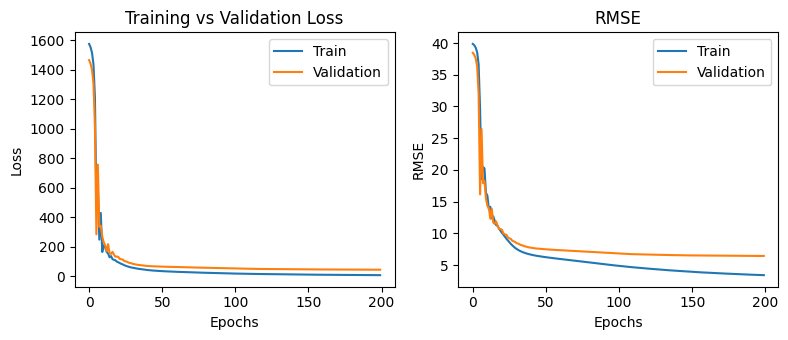

In [ ]:
import matplotlib.pyplot as plt

# Створюємо фігуру з двома підграфіками
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))  # 1 рядок, 2 колонки

# Перший графік: Train Loss
axs[0].plot(train_losses, label='Train')
axs[0].plot(test_losses, label='Validation')
axs[0].set_title('Training vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')

# Другий графік: Test Loss
axs[1].plot(train_rmses, label='Train')
axs[1].plot(test_rmses, label='Validation')
axs[1].set_title('RMSE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('RMSE')
axs[1].legend(loc='best')

# Покажемо графік
plt.tight_layout()  # Для кращого розташування графіків
plt.show()

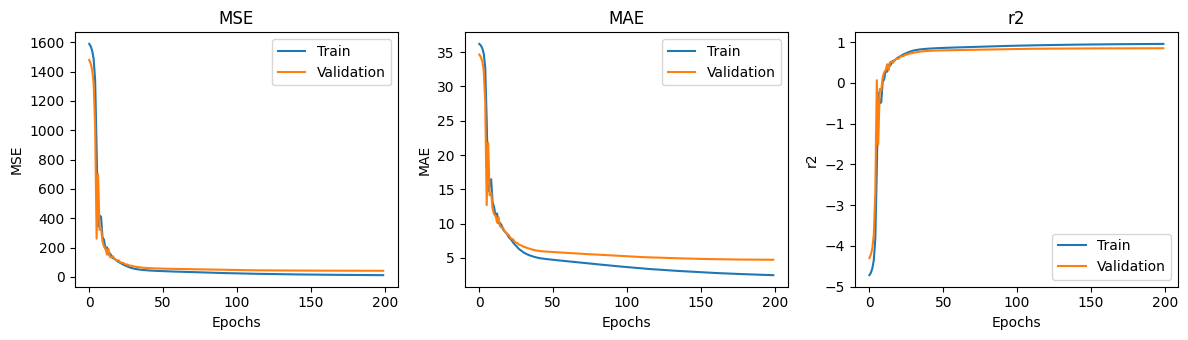

In [ ]:
import matplotlib.pyplot as plt

# Створюємо фігуру з двома підграфіками
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))  # 1 рядок, 2 колонки

# Перший графік: Train Loss
axs[0].plot(train_mses, label='Train')
axs[0].plot(test_mses, label='Validation')
axs[0].set_title('MSE')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('MSE')
axs[0].legend(loc='best')

# Другий графік: Test Loss
axs[1].plot(train_maes, label='Train')
axs[1].plot(test_maes, label='Validation')
axs[1].set_title('MAE')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend(loc='best')

# Другий графік: Test Loss
axs[2].plot(train_r2, label='Train')
axs[2].plot(test_r2, label='Validation')
axs[2].set_title('r2')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('r2')
axs[2].legend(loc='best')

# Покажемо графік
plt.tight_layout()  # Для кращого розташування графіків
plt.show()

### Налаштування:
- В якості функцію втрат було використано MSELoss (Mean Squared Error Loss).
  
  Обґрунтування: MSE є найпоширенішою функцією втрат для задач регресії, оскільки вона штрафує більші помилки сильніше, ніж менші. Мета мінімізації MSE полягає в зменшенні великих відхилень, що дуже корисно, якщо важливі великі помилки.
MSE є диференційованою функцією, що дозволяє ефективно використовувати градієнтний спуск для її мінімізації.
MSE дає чітку оцінку того, наскільки добре модель може наближатися до істинних значень, і працює добре, коли є більші помилки в результатах (що часто трапляється в реальних сценаріях).

- Оптимізатором вибрано SGD.

  Обґрунтування: SGD є більш швидким і може працювати з великими наборами даних.
  До того ж він показав себе краще Adam.

- В якості метрики точності використані всі запропоновані:
  - RMSE,
  - MSE,
  - MAE,
  - r2
  Обґрунтування: Для порівняння результату з вимогами завдання.

### Аналіз результатів:
- Під час навчання моделі ми спостерігали позитивну динаміку зменшення функції втрат. Значення Loss за 200 епох зменшилось то 8.44. Це свідчить про те, що модель поступово навчилася краще узгоджувати свої прогнози з реальними значеннями вхідних даних.
- Зниження значення метрик точності є очікуваним результатом у контексті задачі регресії. RMSE знизилось до 3.57. MSE до 12.78, MAE - до 2.61.
- r2 виросло до 0.954, що є досить високим результатом.
- Візульно на всіх графіках видно що навчання прощодило успішно, шофіки виходили на плато на дуже гарних рівнях.
- Цікавий момент спостерігається на рафіках RMSE та MAE, коли тренувальний та тестовий графіки виходять на плато, тренувальний продовжує повілье навчання, збільшуючи таким чином разрив з тестовим, що може вказувати на перенавчання.


### Висновки:
- Навчання пройшло успішно, і модель демонструє покращену здатність до прогнозування відповідно до поставленої задачі регресії.
- 200 епох навчання, можливо ведуть до початку переначання, тому може бути варто скоротити навчання до 70-100 епох.
- Оптимізатор SGD показав набагато кращий результат на цьому наборі даних ніж Adam.

